# Step A - Multiple Product Detection:
Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. The system should be able to correctly identify all the product in the shelves
image. One way to solve this task could be the use of local invariant feature as explained in lab session 5.

### Source
https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os   

In [2]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

#define color scene
#scene_color = cv.imread(get_path_scene("e3.png"))

#plt.imshow(cv.cvtColor(scene_color, cv.COLOR_RGB2BGR))
#plt.show()

Looking for 0.jpg...
Looking for 11.jpg...
results


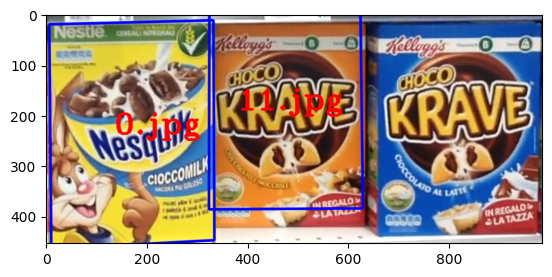

In [3]:
def find_image(scene_path, model_paths, draw_on_color=True):

    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    #create array with all models
    models = []
    for model_gray_path in model_paths:
        
        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        print(f"Looking for {model["name"]}...")

        model_gray = model["img"]
        MIN_MATCH_COUNT = 10

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(model_gray,None)
        kp2, des2 = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
        
        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        result = scene_to_draw_on
        
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w = model_gray.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,
                                            h-1],[w-1,0] ]).reshape(-1,1,2)
            
            dst = cv.perspectiveTransform(pts,M)

            #add square and add text
            means = np.mean(dst, axis=0)
            x, y = [a for a in means[0]]
            x = x * 0.8 #adjust for text
            
            result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

            boldness = 3
            size = 3
            cv.putText(scene_to_draw_on, model["name"], (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
        
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

    print("results")
    return result

#define models to be searched in image
models = [get_path_model(a) for a in [0,11]]

result = find_image(scene_path=get_path_scene("e3.png"),
                    model_paths=models,
                    draw_on_color=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()